Task 1

In [304]:
import requests
import numpy as np
import pandas as pd
import string
from datetime import datetime
from urllib.parse import unquote
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, wait, FIRST_COMPLETED
from collections import OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"
WIKIPEDIA_API_ENDPOINT = "https://en.wikipedia.org/w/api.php"

HEADERS = {"User-Agent": "uni_coursework/2.0; nat.1.roongjirarat@kcl.ac.uk"}

PARAMS_QUERY_SEARCH = {
    "action":"query",
    "format":"json",
    "formatversion":"latest",
    "list":"search",
    "srsearch": "haswbstatement:P166=Q185667",
    "srlimit":"max"
}

PARAMS_GETCONTENT = {
    "action": "query",
    "format": "json",
    "titles": "",
    "prop": "extracts",
    "exlimit": "max"
}

PARAMS_WBGETENTITIES_LABELS = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "sites": "",
    "props": "labels",
    "languages": "en",
    "sitefilter": "enwiki",
    "utf8": 1,
    "ascii": 1,
    "formatversion": "latest"
}

PARAMS_WBGETENTITIES_SITES = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "sites": "",
    "props": "sitelinks/urls",
    "languages": "en",
    "sitefilter": "enwiki",
    "utf8": 1,
    "ascii": 1,
    "formatversion": "latest"
}

PARAMS_WBGETENTITIES_CLAIMS = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "props": "claims",
    "languages": "en",
    "sitefilter": "",
    "formatversion": "latest"
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nat_rng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nat_rng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nat_rng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nat_rng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [256]:
def get_turing_award_recipients():
    acm_award_entities = []
    search_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_QUERY_SEARCH)
    data = search_response.json()
    for result in data['query']['search']:
        acm_award_entities.append(result['title'])
    return acm_award_entities

print(get_turing_award_recipients())

['Q80', 'Q3572699', 'Q92894', 'Q17457', 'Q92612', 'Q92638', 'Q92743', 'Q92824', 'Q181529', 'Q204815', 'Q578036', 'Q92794', 'Q92739', 'Q49823', 'Q92602', 'Q3571662', 'Q92626', 'Q92758', 'Q16080922', 'Q62870', 'Q8556', 'Q92604', 'Q357965', 'Q11609', 'Q92609', 'Q439245', 'Q92670', 'Q92819', 'Q92851', 'Q92613', 'Q62874', 'Q92854', 'Q92628', 'Q7143512', 'Q62861', 'Q320624', 'Q45575', 'Q1107006', 'Q92614', 'Q62888', 'Q93080', 'Q476466', 'Q92820', 'Q92649', 'Q62898', 'Q92641', 'Q92742', 'Q93154', 'Q62843', 'Q92643', 'Q92823', 'Q462089', 'Q62866', 'Q92629', 'Q92618', 'Q92822', 'Q92596', 'Q92746', 'Q918650', 'Q62857', 'Q92619', 'Q92821', 'Q62877', 'Q92781', 'Q92782', 'Q92632', 'Q93161', 'Q92744', 'Q92606', 'Q9602', 'Q92625', 'Q62894', 'Q92644', 'Q92745', 'Q92828']


Task 2

In [257]:
def get_wikipedia_content(entity_id):
    PARAMS_WBGETENTITIES_SITES["ids"] = entity_id
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_SITES)
    wbgetentities_data = wbgetentities_response.json()
    recipient_name = wbgetentities_data["entities"][entity_id]["sitelinks"]["enwiki"]["url"].split("https://en.wikipedia.org/wiki/")[1]

    PARAMS_GETCONTENT["titles"] = unquote(recipient_name)
    extracts_response = requests.get(WIKIPEDIA_API_ENDPOINT, headers=HEADERS, params=PARAMS_GETCONTENT)
    extracts_data = extracts_response.json()
    html_content = next(iter(extracts_data["query"]["pages"].values()))["extract"]
    content = BeautifulSoup(html_content, 'html.parser')
    if content.find("p", {"class":"mw-empty-elt"}):
        content.find("p", {"class":"mw-empty-elt"}).decompose()
    return str(content)

print(get_wikipedia_content("Q7143512"))


<p><b>Patrick M. Hanrahan</b> (born 1954) is an American computer graphics researcher, the Canon USA Professor of Computer Science and Electrical Engineering in the Computer Graphics Laboratory at Stanford University.
His research focuses on rendering algorithms, graphics processing units, as well as scientific illustration and visualization. He has received numerous awards, including the 2019 Turing Award.
</p>
<h2><span id="Education_and_academic_work">Education and academic work</span></h2>
<p>Hanrahan grew up in Green Bay, Wisconsin. He attended the University of Wisconsin–Madison and graduated with a B.S. in nuclear engineering in 1977, continued his education there, and as a graduate student taught a new computer science course in graphics in 1981. One of his first students was an art graduate student, Donna Cox, now known for her art and scientific visualizations. In the 1980s he went to work at the New York Institute of Technology Computer Graphics Laboratory and at Digital Eq

Task 3

In [258]:
wiki_data_dict = {"gender": "P21", "birth_date": "P569", "birth_city": "P19", 
                  "birth_country": "P17", "employer": "P108", "educated_at": "P69"}

def get_wikidata_claims(entity_id):
    PARAMS_WBGETENTITIES_CLAIMS["ids"] = entity_id
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_CLAIMS)
    wbgetentities_data = wbgetentities_response.json()
    claims = next(iter(wbgetentities_data["entities"].values()))["claims"]
    return claims

def get_wikidata_label(entity_query):
    PARAMS_WBGETENTITIES_LABELS["ids"] = entity_query
    request_ids = set(entity_query.split("|"))
    request_labels = dict()
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_LABELS)
    wbgetentities_data = wbgetentities_response.json()
    for request_id in request_ids:
        labels = wbgetentities_data["entities"][request_id]["labels"]
        request_labels[request_id] = labels["en"]["value"]
    return request_labels

def check_key_exists(dict, key):
    if key in dict.keys():
        entity_ids = [dict[key][i]["mainsnak"]["datavalue"]["value"]["id"] for i in range(len(dict[key]))]
        return entity_ids
    else:
        return None

def call_wikidata_api(entity_id):
    claims = get_wikidata_claims(entity_id)
    request_entityids = {"name_id": [entity_id], "gender_id": check_key_exists(claims, wiki_data_dict["gender"]),
                       "birth_city_id" : check_key_exists(claims, wiki_data_dict["birth_city"]),
                       "employers_ids": check_key_exists(claims, wiki_data_dict["employer"]),
                       "educated_at_ids": check_key_exists(claims, wiki_data_dict["educated_at"])}
    
    
    entity_query = "|".join(["|".join(values) for values in request_entityids.values() if values != None])
    request_labels = get_wikidata_label(entity_query)
    
    try:
        name = request_labels[request_entityids["name_id"][0]].split(" (")[0]
    except TypeError:
        name = None
    try:
        intro = get_wikipedia_content(entity_id).split("<h2>")[0]
    except TypeError:
        intro = None   
    try: 
        gender = request_labels[request_entityids["gender_id"][0]]
    except TypeError:
        gender = None
    try:
        birth_date = datetime.strptime(claims[wiki_data_dict["birth_date"]][0]["mainsnak"]["datavalue"]["value"]["time"], "+%Y-%m-%dT%XZ").strftime("%d %B %Y")
    except ValueError:
        birth_date = datetime.strptime(claims[wiki_data_dict["birth_date"]][0]["mainsnak"]["datavalue"]["value"]["time"], "+%Y-00-00T%XZ").strftime("%Y")
    except TypeError:
        birth_date = None
    try:
        birth_place = request_labels[request_entityids["birth_city_id"][0]] 
    except TypeError:
        birth_place = None
    if request_entityids["employers_ids"] != None:
        employer = [request_labels[key] for key in request_entityids["employers_ids"]]
    else:
        employer = None
    if request_entityids["employers_ids"] != None:
        education = [request_labels[key] for key in request_entityids["educated_at_ids"]]
    else:
        education = None
    return name, intro, gender, birth_date, birth_place, employer, education

def multi_thread_api_call(entity_ids, workers=10):
    results = []
    
    with ThreadPoolExecutor(max_workers=workers) as executor:
        api_calls = {executor.submit(call_wikidata_api, entity_id): entity_id for entity_id in entity_ids}
        while api_calls:
            retry_api_calls = {}
            done, pending = wait(api_calls, return_when=FIRST_COMPLETED)
            for api_call in done:
                if api_call.exception():
                    entity_id = api_calls[api_call]
                    retry_api_calls[executor.submit(call_wikidata_api, entity_id)] = entity_id
                else:
                    results.append(api_call.result())
            for api_call in pending:
                entity_id = api_calls[api_call]
                retry_api_calls[api_call] = entity_id
            api_calls = retry_api_calls    
    return results

def get_award_winners_data(results, award_winners_dict):
    for result in results:
        name, intro, gender, birth_date, birth_place, employer, education = result
        award_winners_dict["name"].append(name)
        award_winners_dict["intro"].append(intro)
        award_winners_dict["gender"].append(gender)
        award_winners_dict["birth_date"].append(birth_date)
        award_winners_dict["birth_place"].append(birth_place)
        award_winners_dict["employer"].append(employer)
        award_winners_dict["educated_at"].append(education)
    return award_winners_dict

award_winners_dict = {"name": [], "intro": [], "gender": [], "birth_date": [], 
                      "birth_place": [], "employer": [], "educated_at": []} 
acm_award_winners = get_turing_award_recipients()
api_calls = multi_thread_api_call(acm_award_winners)
 
award_winners = get_award_winners_data(api_calls, award_winners_dict)

Task 4

In [259]:
for name in sorted(award_winners["name"]):
    print(name)

Adi Shamir
Alan Kay
Alan Perlis
Alfred Aho
Allen Newell
Amir Pnueli
Andrew Yao
Barbara Liskov
Bob Kahn
Butler Lampson
Charles Bachman
Charles P. Thacker
Dana Scott
David A. Patterson
Dennis M. Ritchie
Donald Knuth
Douglas Engelbart
E. Allen Emerson
Edgar F. Codd
Edmund M. Clarke
Edsger W. Dijkstra
Edward Feigenbaum
Edwin Catmull
Fernando J. Corbató
Frances E. Allen
Fred Brooks
Geoffrey Hinton
Herbert Simon
Iosif Sifakis
Ivan Sutherland
Jack Dongarra
James H. Wilkinson
Jeffrey David Ullman
Jim Gray
John Backus
John Cocke
John Edward Hopcroft
John L. Hennessy
John McCarthy
Judea Pearl
Juris Hartmanis
Ken Thompson
Kenneth E. Iverson
Kristen Nygaard
Leonard Adleman
Leslie Lamport
Leslie Valiant
Manuel Blum
Martin Edward Hellman
Marvin Minsky
Maurice Wilkes
Michael O. Rabin
Michael Stonebraker
Niklaus Wirth
Ole-Johan Dahl
Pat Hanrahan
Peter Naur
Raj Reddy
Richard E. Stearns
Richard Hamming
Richard M. Karp
Robert Tarjan
Robert W. Floyd
Robin Milner
Ron Rivest
Shafrira Goldwasser
Silvio Mical

Task 5

In [260]:
award_winners_intro = pd.DataFrame(columns=["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])
award_winners_intro["winner_name"] = award_winners["name"]

def get_intro_stats(intro): 
    intro_html = BeautifulSoup(intro, "html.parser")
    intro_text = intro_html.get_text(" ")
    count_words = sum([word.strip(string.punctuation).isalnum() for word in intro_text.split()])
    count_sentences = len(sent_tokenize(intro_text))
    count_paragraphs = len(intro_html.find_all("p"))
    word_filter = set(list(string.punctuation) + ["``", "''", "–"])
    word_freqdist= nltk.FreqDist([word for word in word_tokenize(intro_text) if word not in word_filter]).most_common(10)
    common_words = [word[0] for word in word_freqdist]
    return count_words, count_sentences, count_paragraphs, common_words

intro_stats = {"word_count": [], "sentence_count": [], "paragraph_count": [], "common_words": []}
for intro in award_winners["intro"]:
    count_word, count_sentences, count_paragraphs, common_words = get_intro_stats(intro)
    intro_stats["word_count"].append(count_word)
    intro_stats["sentence_count"].append(count_sentences)
    intro_stats["paragraph_count"].append(count_paragraphs)
    intro_stats["common_words"].append(common_words)

award_winners_intro["count_words"] = intro_stats["word_count"]
award_winners_intro["count_sentences"] = intro_stats["sentence_count"]
award_winners_intro["count_paragraphs"] = intro_stats["paragraph_count"]
award_winners_intro["common_words"] = intro_stats["common_words"]


pd.set_option('display.max_rows', None)
award_winners_intro

,winner_name,count_words,count_sentences,count_paragraphs,common_words
0,Judea Pearl,154,5,2,"[the, and, for, of, Pearl, is, on, a, in, Judea]"
1,Tim Berners-Lee,348,17,4,"[the, of, and, Web, He, a, is, as, World, Wide]"
2,Geoffrey Hinton,176,8,3,"[the, and, of, for, in, Hinton, a, his, to, is]"
3,Donald Knuth,182,8,3,"[the, of, and, Knuth, computer, is, to, He, sc..."
4,Robert Tarjan,59,3,1,"[and, Tarjan, is, the, of, University, at, Rob..."
5,Herbert Simon,175,7,2,"[the, of, and, was, in, science, to, political..."
6,Vint Cerf,62,2,1,"[the, of, and, is, Internet, National, Medal, ..."
7,Marvin Minsky,51,2,2,"[and, of, AI, Minsky, the, Marvin, Lee, August..."
8,Yoshua Bengio,90,4,2,"[and, the, of, Bengio, for, is, a, work, deep,..."
9,Richard M. Karp,91,3,2,"[in, and, the, of, for, Karp, is, computer, th..."


Task 5

In [261]:
def process_common_words(intro):
    intro_text = BeautifulSoup(intro, "html.parser").get_text(" ")
    word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
    tokenized_intro = word_tokenize(intro_text)
    word_freqdist = nltk.FreqDist([word for word in tokenized_intro if word not in word_filter]).most_common(10)
    common_words = [word[0] for word in word_freqdist]
    return common_words

common_words_after_preprocessing = [process_common_words(intro) for intro in award_winners["intro"]]
award_winners_intro["common_words_after_preprocessing"] = common_words_after_preprocessing

print(award_winners_intro.head(10))

       winner_name  count_words  count_sentences  count_paragraphs  \
0      Judea Pearl          154                5                 2   
1  Tim Berners-Lee          348               17                 4   
2  Geoffrey Hinton          176                8                 3   
3     Donald Knuth          182                8                 3   
4    Robert Tarjan           59                3                 1   
5    Herbert Simon          175                7                 2   
6        Vint Cerf           62                2                 1   
7    Marvin Minsky           51                2                 2   
8    Yoshua Bengio           90                4                 2   
9  Richard M. Karp           91                3                 2   

                                        common_words  \
0   [the, and, for, of, Pearl, is, on, a, in, Judea]   
1    [the, of, and, Web, He, a, is, as, World, Wide]   
2    [the, and, of, for, in, Hinton, a, his, to, is]   
3  [t

3.2 Sub Activity

Task 3

In [262]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])

word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
tokenized_intro = word_tokenize(long_intro_text)
intro_words = [word for word in tokenized_intro if word not in word_filter]

print("Number of unique words before stemming with Porter Stemmer: {}".format(len(list(nltk.FreqDist(intro_words)))))

porter_stemmer = PorterStemmer()
intro_words = [porter_stemmer.stem(word) for word in intro_words]

print("Number of unique words after stemming with Porter Stemmer: {}".format(len(list(nltk.FreqDist(intro_words)))))

Number of unique words before stemming with Porter Stemmer: 1768
Number of unique words after stemming with Porter Stemmer: 1466


Task 4

In [263]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])

word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
tokenized_intro = word_tokenize(long_intro_text)
intro_words = [word for word in tokenized_intro if word not in word_filter]

print("Number of unique words before stemming with Snowball Stemmer: {}".format(len(list(nltk.FreqDist(intro_words)))))

snow_stemmer = SnowballStemmer(language='english')
intro_words = [snow_stemmer.stem(word) for word in intro_words]

print("Number of unique words after stemming with Snowball Stemmer: {}".format(len(list(nltk.FreqDist(intro_words)))))

Number of unique words before stemming with Snowball Stemmer: 1768
Number of unique words after stemming with Snowball Stemmer: 1464


Task 5

In [264]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])

word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
tokenized_intro = word_tokenize(long_intro_text)
intro_words = [word for word in tokenized_intro if word not in word_filter]

print("Number of unique words before lemmatization with Word Net Lemmatizer: {}".format(len(list(nltk.FreqDist(intro_words)))))

wordnet_lemmatizer = WordNetLemmatizer()
intro_words = [wordnet_lemmatizer.lemmatize(word) for word in intro_words]

print("Number of unique words after lemmatization with Word Net Lemmatizer: {}".format(len(list(nltk.FreqDist(intro_words)))))

Number of unique words before lemmatization with Word Net Lemmatizer: 1768
Number of unique words after lemmatization with Word Net Lemmatizer: 1717


Task 6

In [265]:
award_winners_intro = award_winners_intro.assign(synonyms = np.nan, antonyms = np.nan)
common_words_after_preprocessing = award_winners_intro["common_words_after_preprocessing"]

def get_synonyms(common_words):
    synonyms = [l.name() for word in common_words for syn in wordnet.synsets(word) for l in syn.lemmas() if l.name() != word]
    return list(OrderedDict.fromkeys(synonyms))

def get_antonyms(common_words):
    antonyms = [l.antonyms()[0].name() for word in common_words for syn in wordnet.synsets(word) for l in syn.lemmas() if l.antonyms()]
    return list(OrderedDict.fromkeys(antonyms))

for i in range(len(common_words_after_preprocessing)):
    synonyms, antonyms = get_synonyms(common_words_after_preprocessing[i]), get_antonyms(common_words_after_preprocessing[i])
    award_winners_intro["synonyms"][i] = synonyms
    award_winners_intro["antonyms"][i] = antonyms

award_winners_intro.head(10)

/tmp/ipykernel_439/2150364489.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  award_winners_intro["synonyms"][i] = synonyms
/tmp/ipykernel_439/2150364489.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  award_winners_intro["antonyms"][i] = antonyms


,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Judea Pearl,154,5,2,"[the, and, for, of, Pearl, is, on, a, in, Judea]","[Pearl, Judea, computer, probabilistic, artifi...","[pearl, bone, ivory, off-white, drop, bead, Ju...","[natural, stupidity, devolution, nondevelopment]"
1,Tim Berners-Lee,348,17,4,"[the, of, and, Web, He, a, is, as, World, Wide]","[Web, He, World, Wide, Berners-Lee, 's, Comput...","[web, entanglement, vane, network, World_Wide_...","[narrow, middle, last, second]"
2,Geoffrey Hinton,176,8,3,"[the, and, of, for, in, Hinton, a, his, to, is]","[Hinton, computer, work, neural, networks, Goo...","[computing_machine, computing_device, data_pro...","[idle, malfunction, shallow]"
3,Donald Knuth,182,8,3,"[the, of, and, Knuth, computer, is, to, He, sc...","[Knuth, computer, He, science, analysis, algor...","[computing_machine, computing_device, data_pro...",[synthesis]
4,Robert Tarjan,59,3,1,"[and, Tarjan, is, the, of, University, at, Rob...","[Tarjan, University, Robert, Endre, born, Apri...","[university, Henry_M._Robert, Henry_Martyn_Rob...",[unborn]
5,Herbert Simon,175,7,2,"[the, of, and, was, in, science, to, political...","[science, political, computer, He, Simon, 2001...","[scientific_discipline, skill, computing_machi...",[nonpolitical]
6,Vint Cerf,62,2,1,"[the, of, and, is, Internet, National, Medal, ...","[Internet, National, Medal, Vinton, Gray, Cerf...","[internet, net, cyberspace, national, subject,...","[international, local, unborn]"
7,Marvin Minsky,51,2,2,"[and, of, AI, Minsky, the, Marvin, Lee, August...","[AI, Minsky, Marvin, Lee, August, 9, 1927, Jan...","[Army_Intelligence, artificial_intelligence, t...",[windward]
8,Yoshua Bengio,90,4,2,"[and, the, of, Bengio, for, is, a, work, deep,...","[Bengio, work, deep, learning, Learning, Hinto...","[piece_of_work, employment, study, workplace, ...","[idle, malfunction, shallow, unborn]"
9,Richard M. Karp,91,3,2,"[in, and, the, of, for, Karp, is, computer, th...","[Karp, computer, theory, algorithms, Richard, ...","[computing_machine, computing_device, data_pro...",[unborn]


Task 7

In [266]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])

word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
tokenized_intro = word_tokenize(long_intro_text)
intro_words = [word for word in tokenized_intro if word not in word_filter]

Task 8

In [267]:
def get_bigrams_frequency(words_list):
    bigrams = nltk.bigrams(words_list)
    bigrams_freqdist = nltk.FreqDist(bigrams)
    return bigrams_freqdist

Task 9

In [268]:
winners_bigrams = dict(get_bigrams_frequency(intro_words))

Task 10

In [292]:
top15_bigrams = dict(sorted(winners_bigrams.items(), key=lambda bigram_dict: bigram_dict[1], reverse=True)[:15])

print("Top 15 bigrams: {}".format(top15_bigrams.keys()))

Top 15 bigrams: dict_keys([('computer', 'scientist'), ('Turing', 'Award'), ('American', 'computer'), ('computer', 'science'), ('Computer', 'Science'), ('He', 'also'), ('programming', 'language'), ('best', 'known'), ('He', 'received'), ('artificial', 'intelligence'), ('National', 'Academy'), ('programming', 'languages'), ('received', 'Turing'), ('Carnegie', 'Mellon'), ('Academy', 'Engineering')])


Task 11

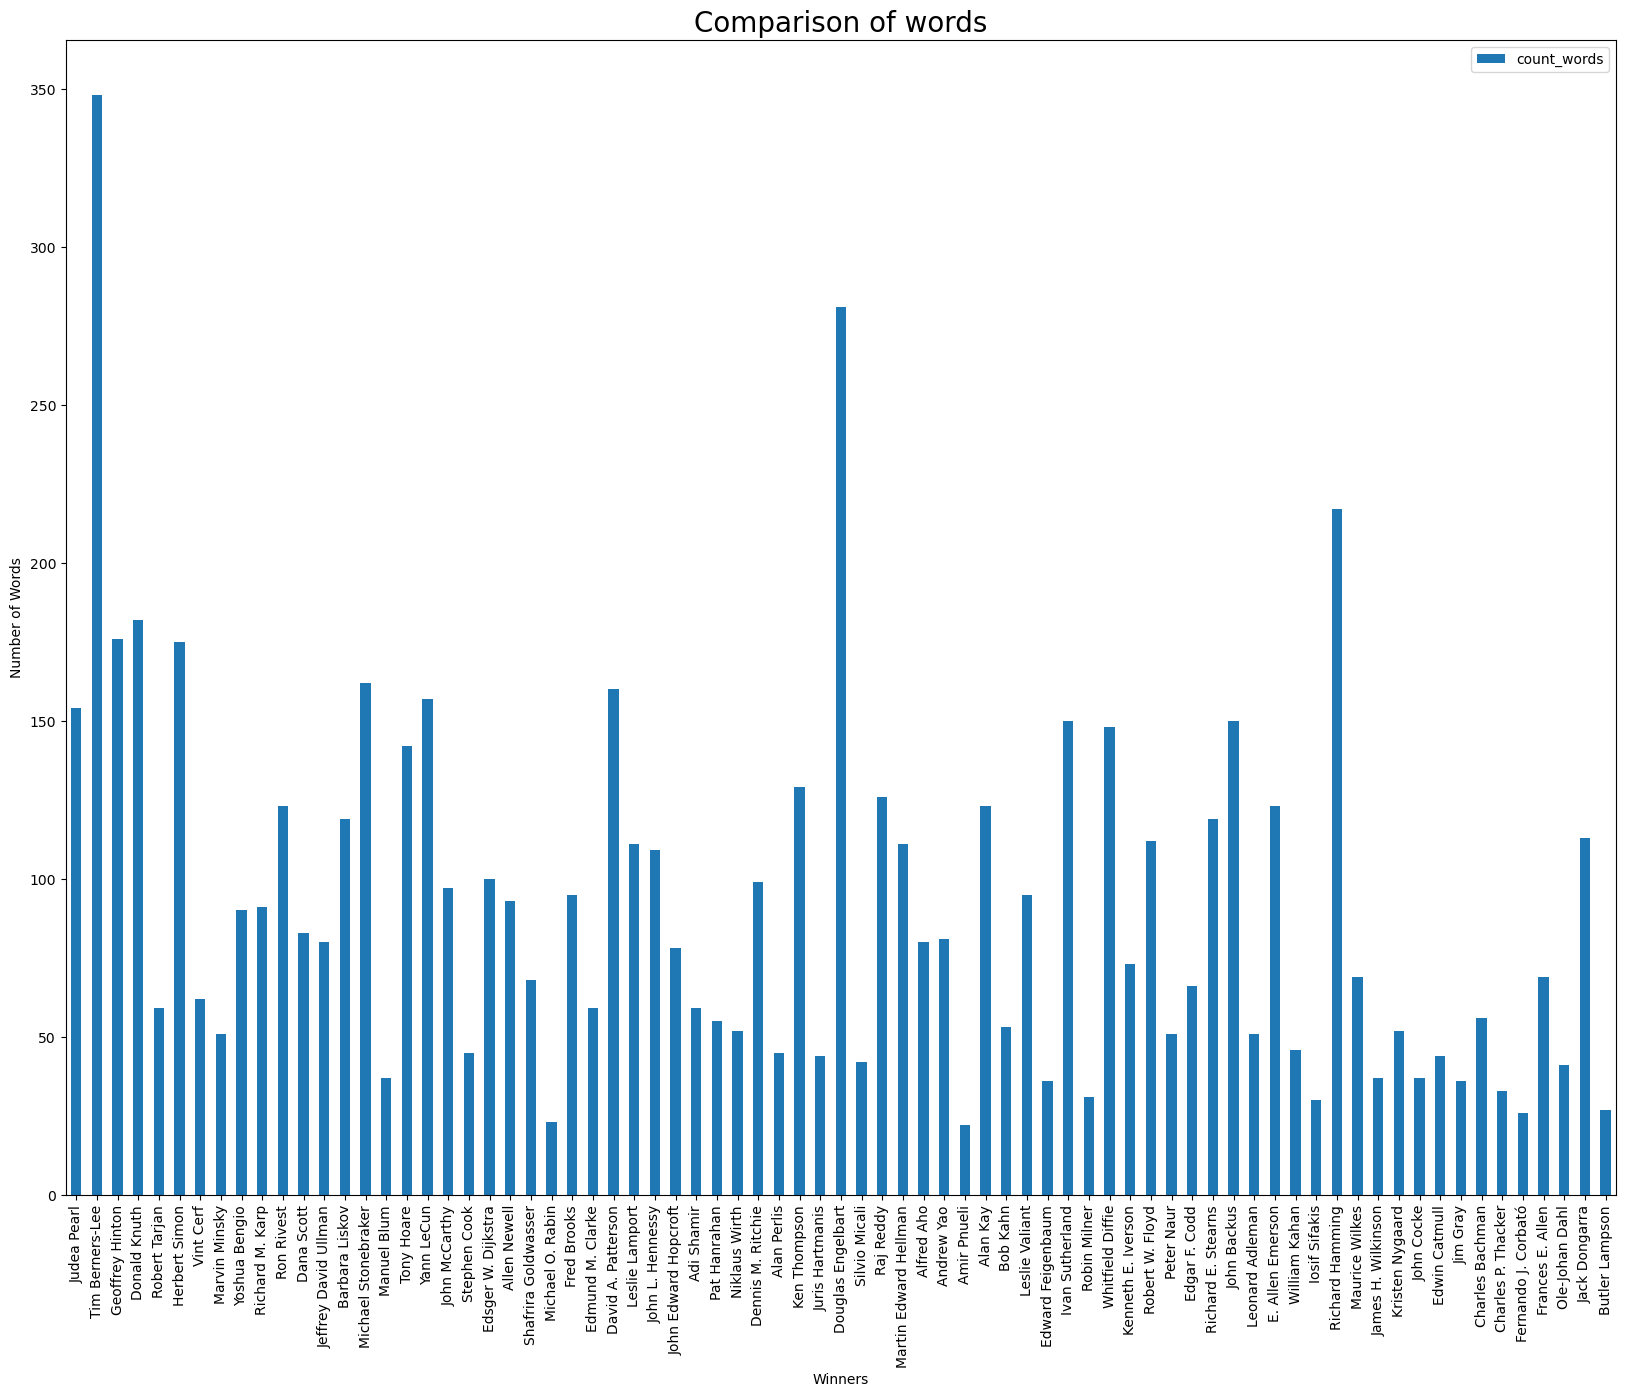

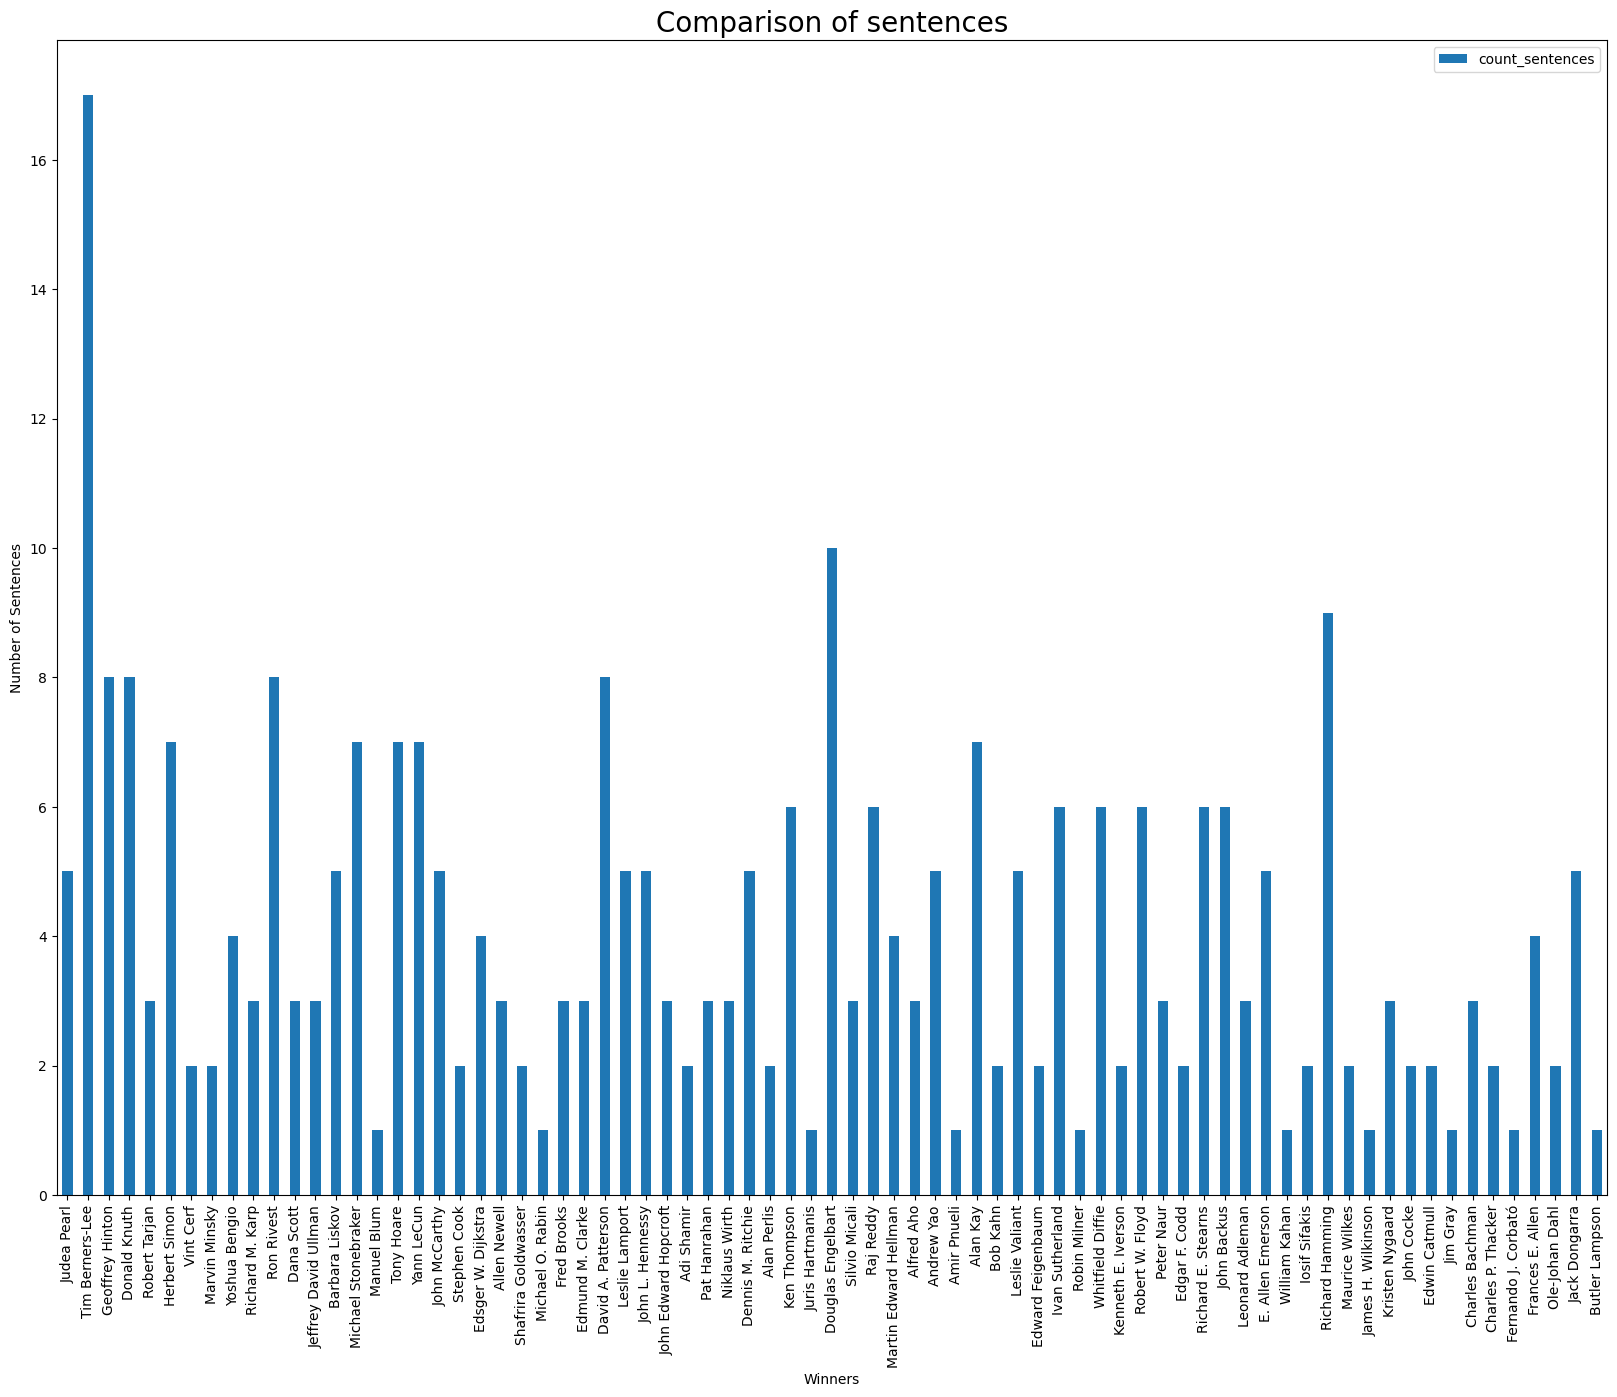

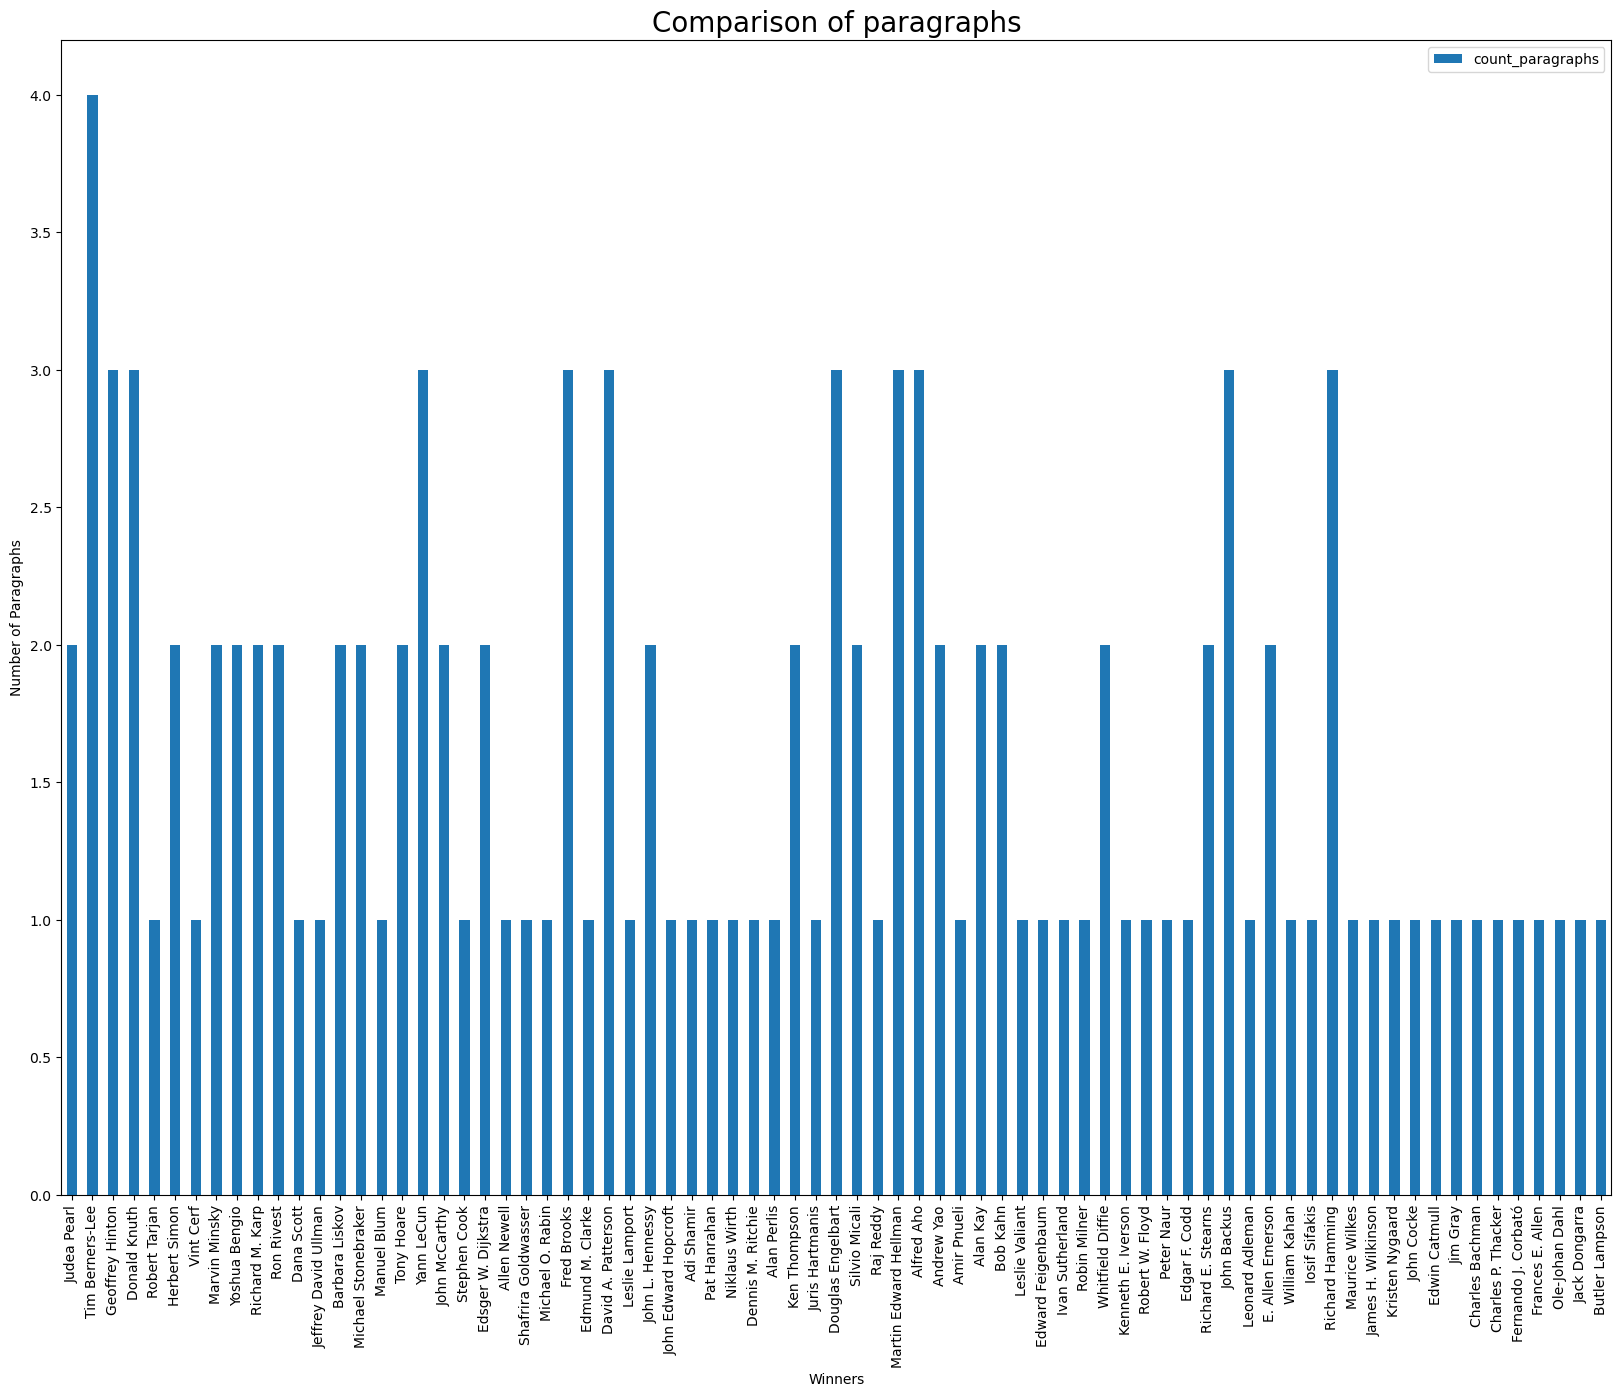

In [270]:
word_comparison = award_winners_intro.plot(x="winner_name", y="count_words", kind='bar', title ="Comparison of words", 
                                           figsize=(20, 15), legend=True)
word_comparison.set_xlabel("Winners")
word_comparison.set_ylabel("Number of Words")
plt.show()

sentence_comparison = award_winners_intro.plot(x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentences", 
                                               figsize=(20, 15), legend=True)
sentence_comparison.set_xlabel("Winners")
sentence_comparison.set_ylabel("Number of Sentences")
plt.xticks(range(len(award_winners_intro["winner_name"])), award_winners_intro["winner_name"])
plt.show()

paragraph_comparison = award_winners_intro.plot(x="winner_name", y="count_paragraphs", kind='bar', title ="Comparison of paragraphs", 
                                                figsize=(20, 15), legend=True)
paragraph_comparison.set_xlabel("Winners")
paragraph_comparison.set_ylabel("Number of Paragraphs")
plt.xticks(range(len(award_winners_intro["winner_name"])), award_winners_intro["winner_name"])
plt.show()

Task 12

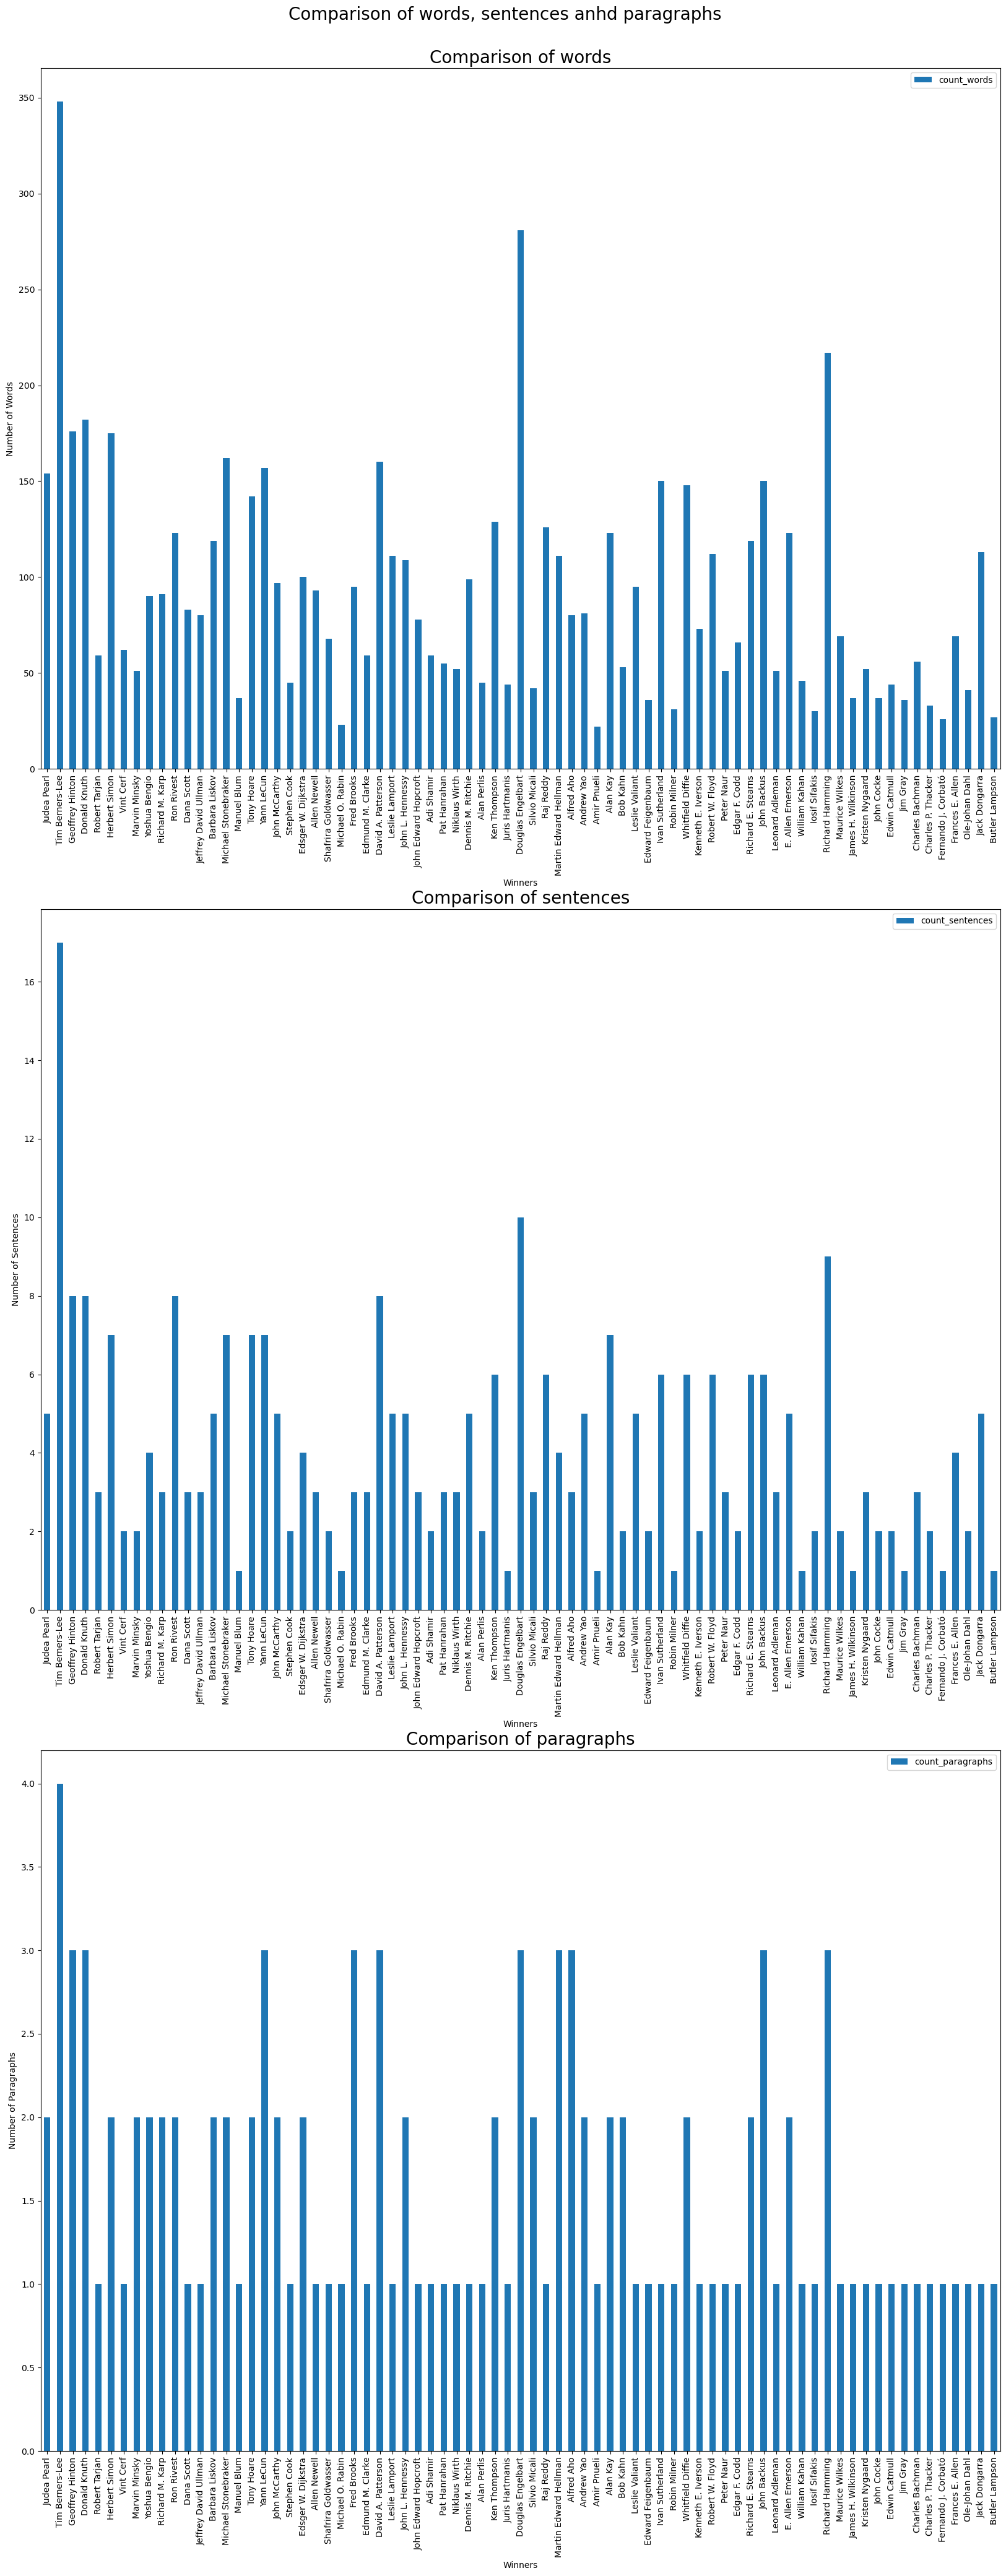

In [271]:
fig, axes = plt.subplots(3, figsize=(20, 50))
fig.suptitle("Comparison of words, sentences anhd paragraphs", x = 0.5, y = 0.90, fontsize = 20)

word_comparison = award_winners_intro.plot(ax = axes[0], x="winner_name", y="count_words", kind='bar', title ="Comparison of words", 
                                           legend=True)
word_comparison.set_xlabel("Winners")
word_comparison.set_ylabel("Number of Words")

sentence_comparison = award_winners_intro.plot(ax = axes[1], x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentences", 
                                               legend=True)
sentence_comparison.set_xlabel("Winners")
sentence_comparison.set_ylabel("Number of Sentences")

paragraph_comparison = award_winners_intro.plot(ax = axes[2], x="winner_name", y="count_paragraphs", kind='bar', title ="Comparison of paragraphs", 
                                                legend=True)
paragraph_comparison.set_xlabel("Winners")
paragraph_comparison.set_ylabel("Number of Paragraphs")

plt.show()

Task 13

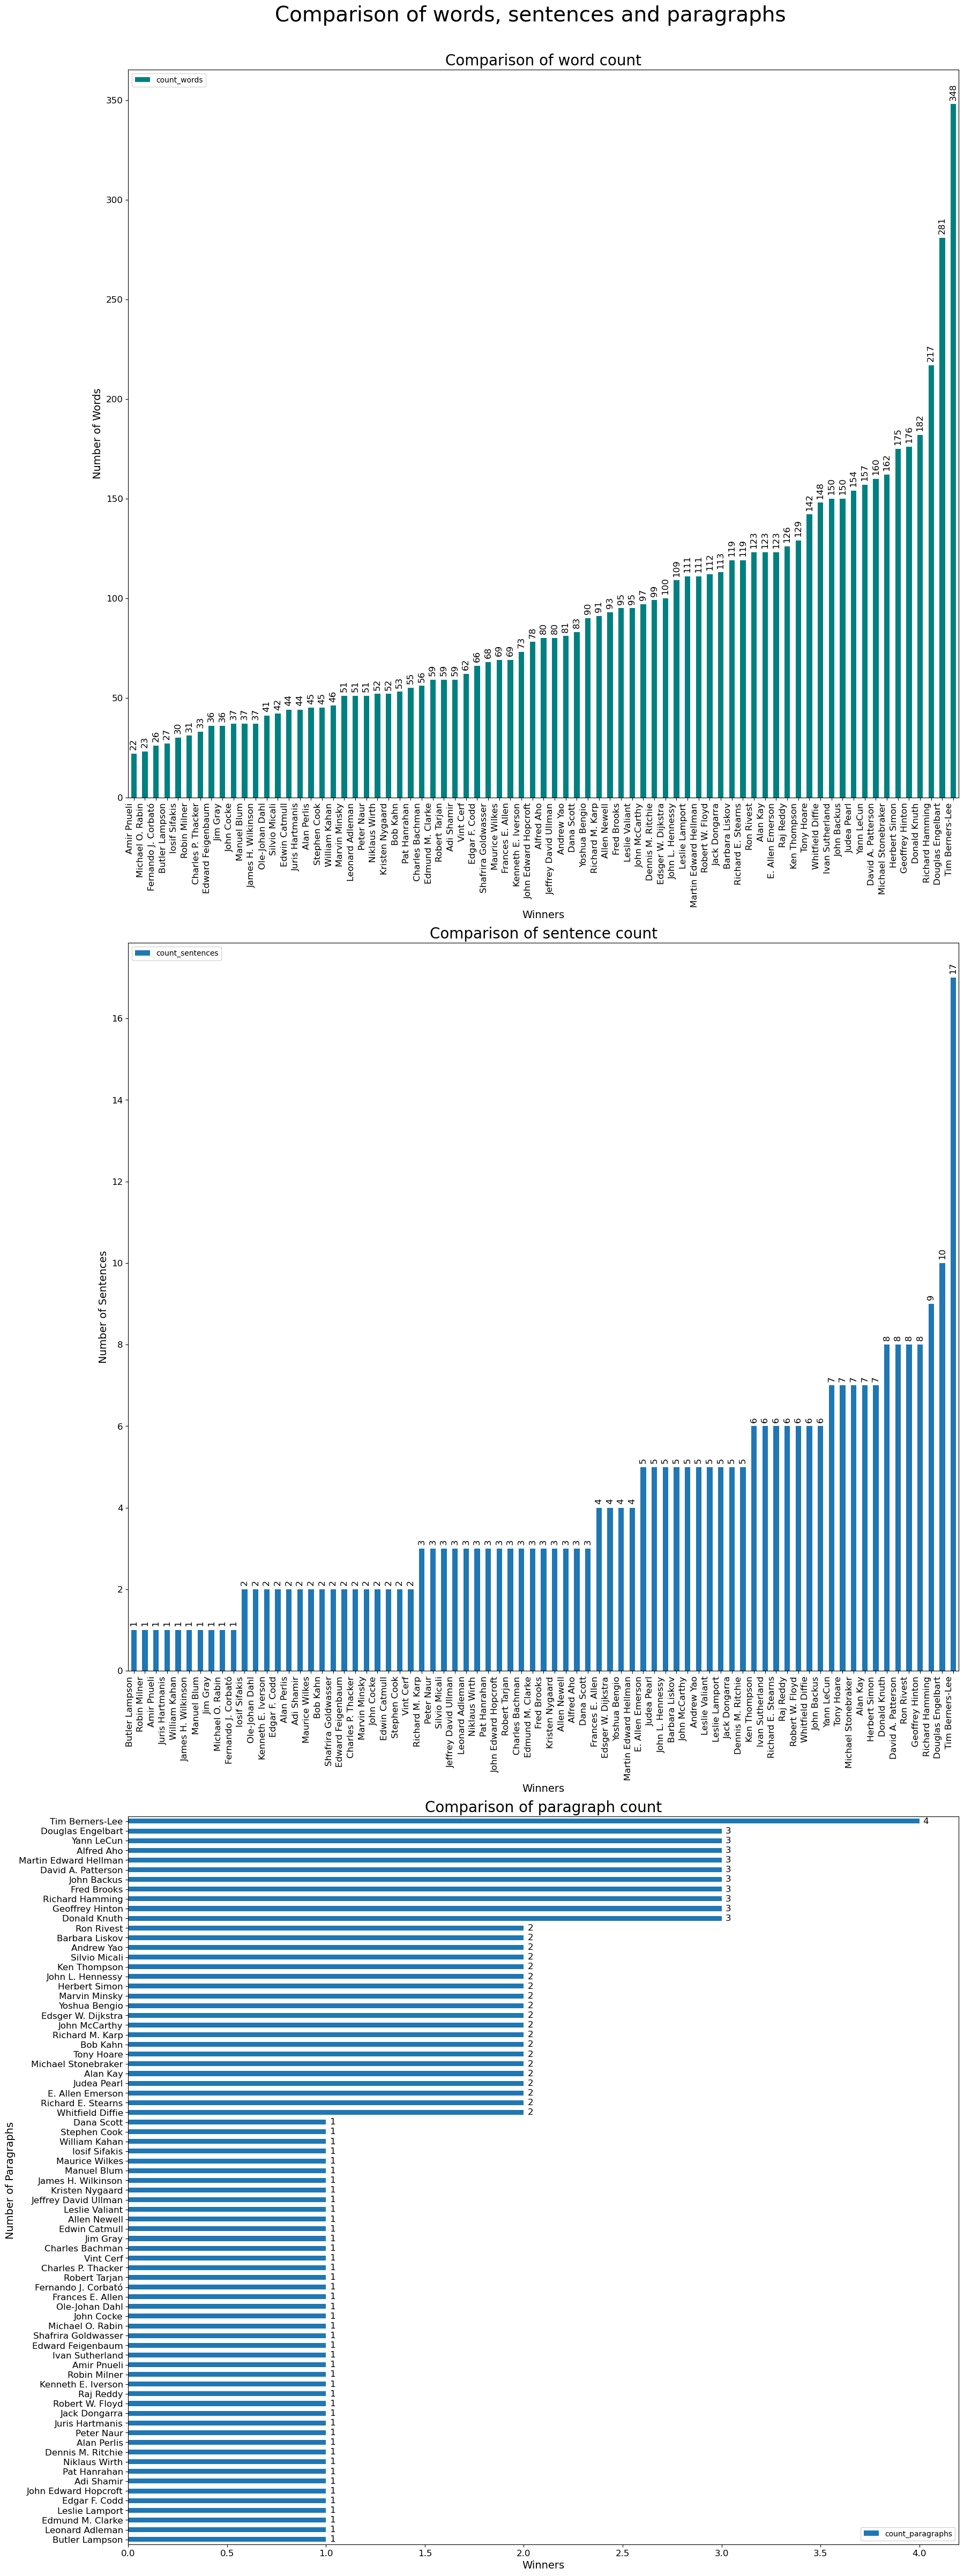

In [289]:
fig, axes = plt.subplots(3, figsize=(20, 60))
fig.suptitle("Comparison of words, sentences and paragraphs", x = 0.5, y = 0.90, fontsize = 28)
plt.rc('axes', titlesize = 20)
text_fontsize = 12
label_fontsize = 14

sorted_word_counts = award_winners_intro.sort_values("count_words").reset_index(drop=True)
sorted_sentence_counts = award_winners_intro.sort_values("count_sentences").reset_index(drop=True)
sorted_paragraph_counts = award_winners_intro.sort_values("count_paragraphs").reset_index(drop=True)

word_comparison = sorted_word_counts.plot(ax = axes[0], x="winner_name", y="count_words", kind='bar', title ="Comparison of word count", 
                                           legend=True, color="teal", fontsize=text_fontsize)                              
word_comparison.set_xlabel("Winners", fontsize=label_fontsize)
word_comparison.set_ylabel("Number of Words", fontsize=label_fontsize)
word_comparison.set_xticklabels(sorted_word_counts["winner_name"], rotation=90, ha='right')
word_comparison.bar_label(word_comparison.containers[0], rotation = 90, padding = 5, fontsize = text_fontsize)
word_comparison.legend(loc="upper left")

sentence_comparison = sorted_sentence_counts.plot(ax = axes[1], x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentence count", 
                                               legend=True, fontsize=text_fontsize)
sentence_comparison.set_xlabel("Winners", fontsize=label_fontsize)
sentence_comparison.set_ylabel("Number of Sentences", fontsize=label_fontsize)
sentence_comparison.set_xticklabels(sorted_sentence_counts["winner_name"], rotation=90, ha='right')
sentence_comparison.bar_label(sentence_comparison.containers[0], rotation = 90, padding = 5, fontsize = text_fontsize)
sentence_comparison.legend(loc="upper left")

paragraph_comparison = sorted_paragraph_counts.plot(ax = axes[2], x="winner_name", y="count_paragraphs", kind='barh', title ="Comparison of paragraph count", 
                                                legend=True, fontsize=text_fontsize)
paragraph_comparison.set_xlabel("Winners", fontsize=label_fontsize)
paragraph_comparison.set_ylabel("Number of Paragraphs", fontsize=label_fontsize)
paragraph_comparison.bar_label(paragraph_comparison.containers[0], padding = 5, fontsize = text_fontsize)

plt.show()

Task 14

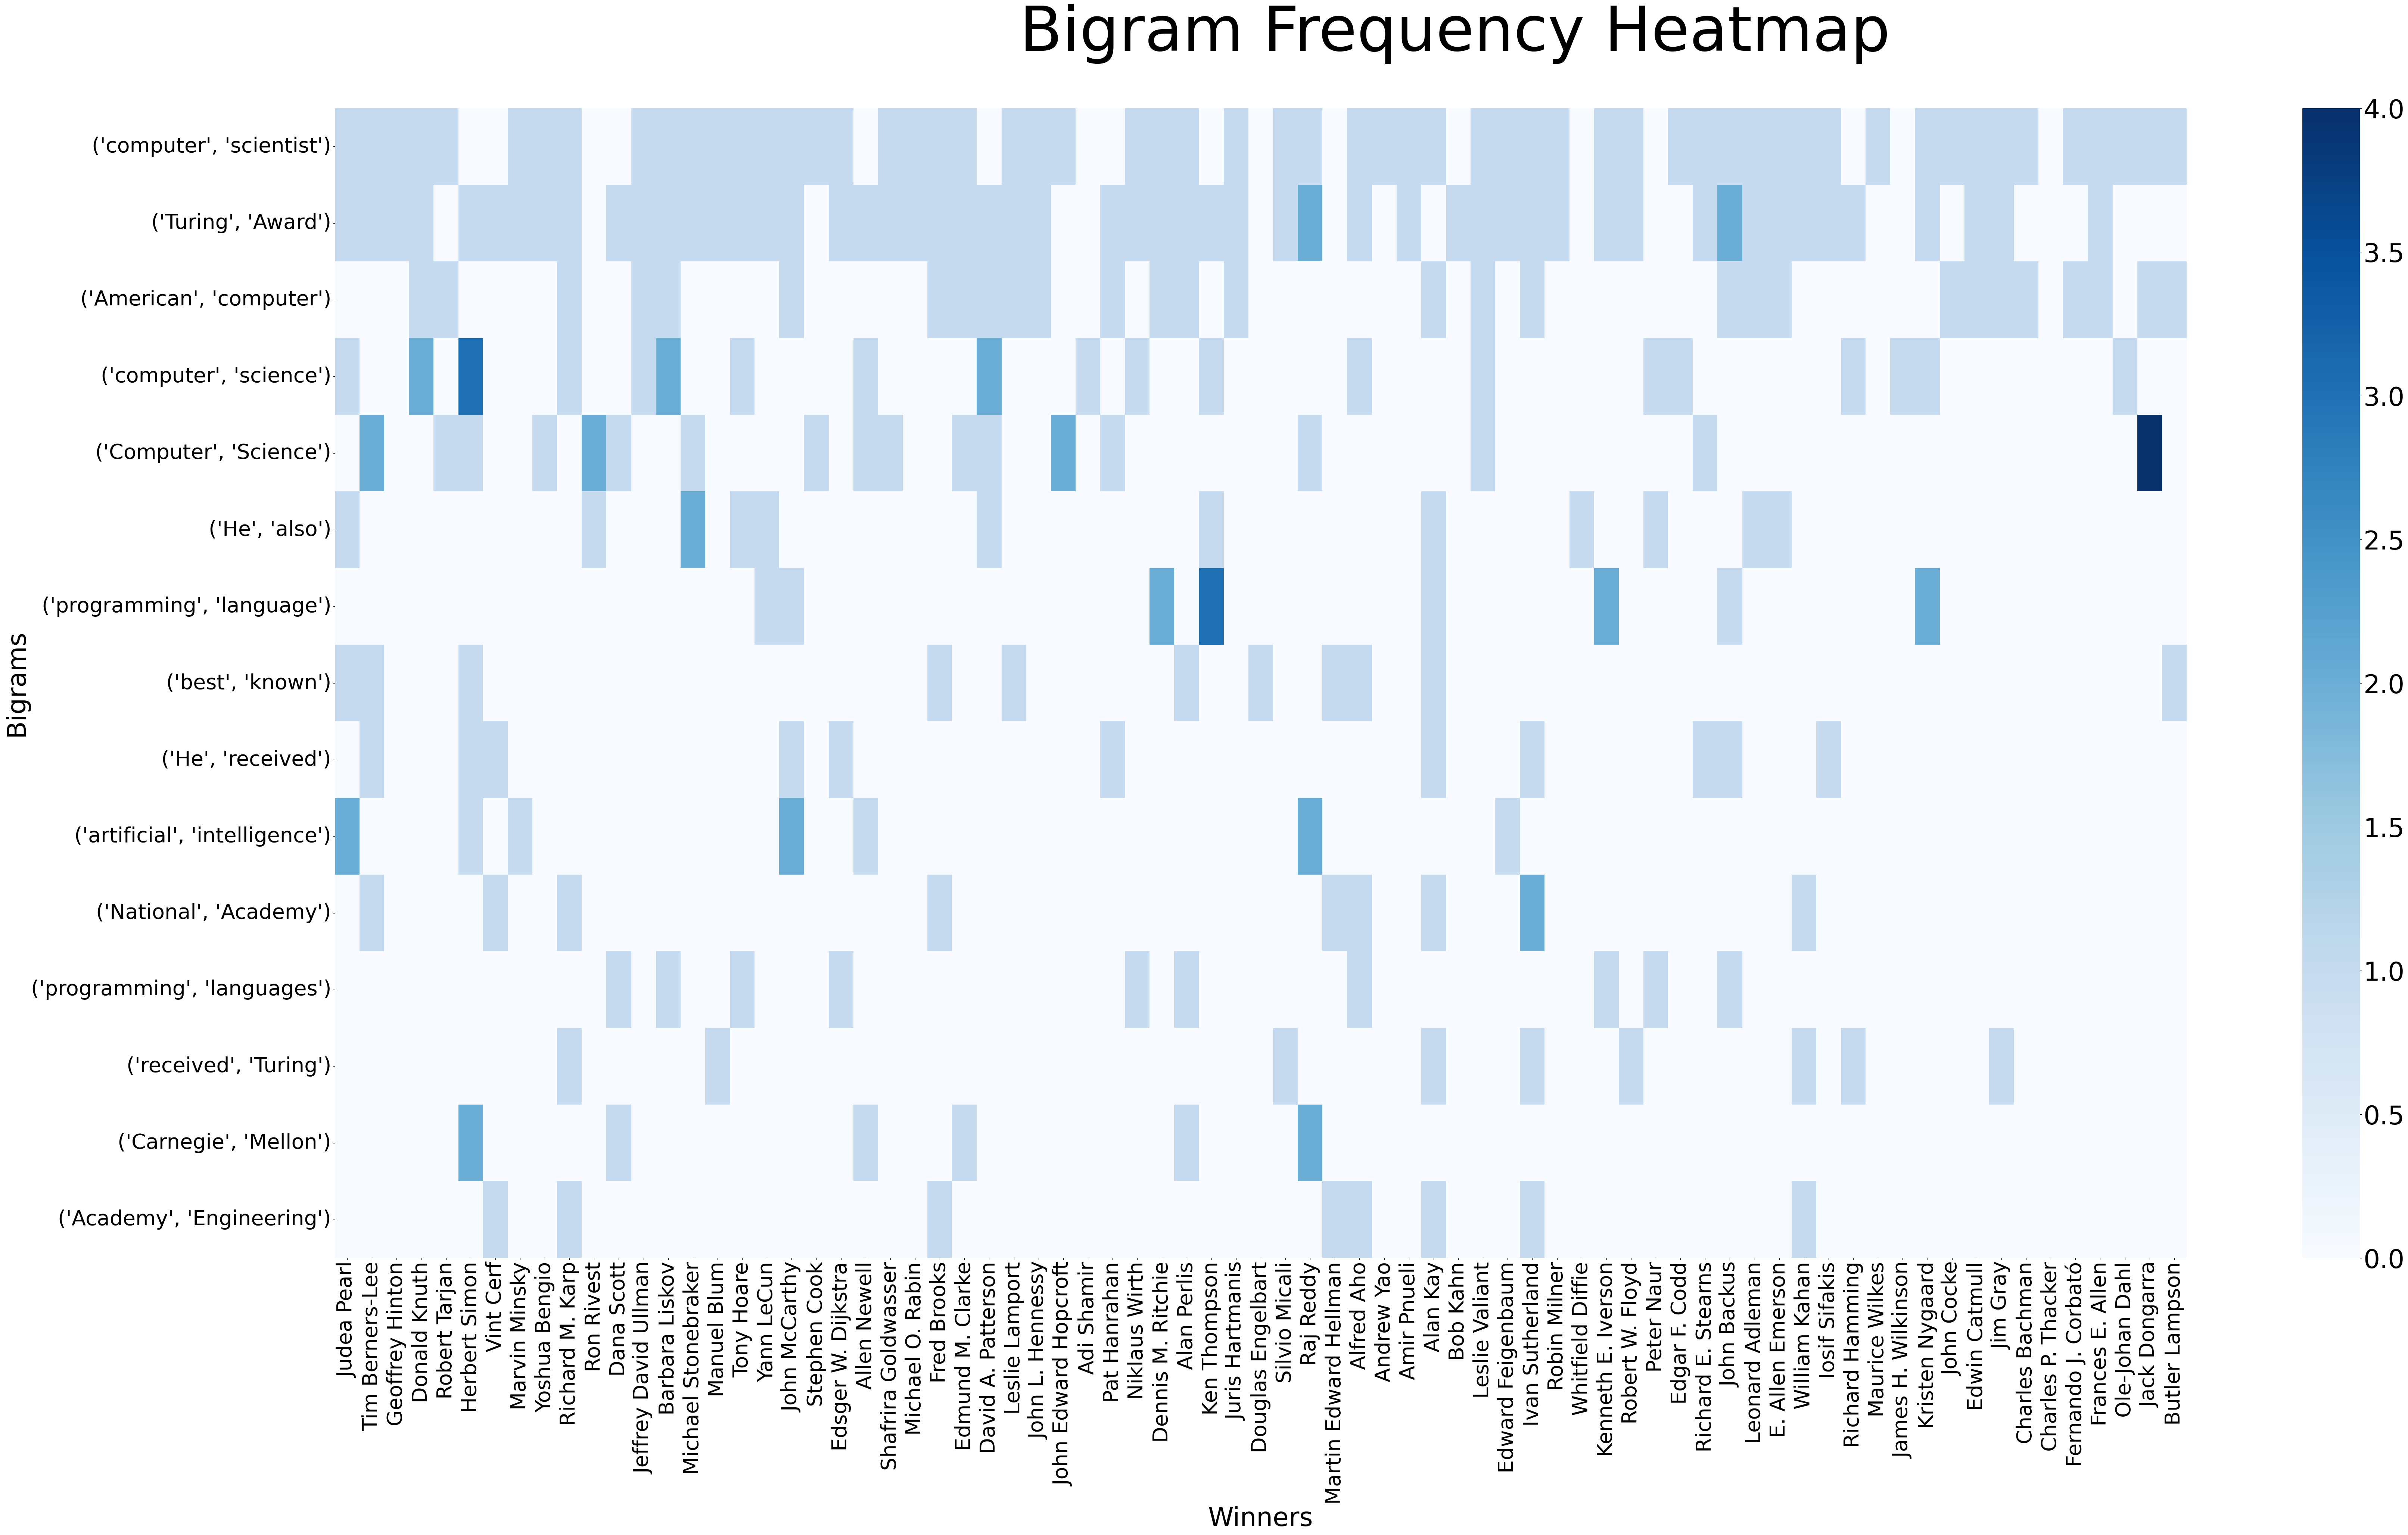

In [404]:
word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])

combined_intro_texts = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
combined_tokenized_intros = word_tokenize(combined_intro_texts)
combined_intro_words = [word for word in combined_tokenized_intros if word not in word_filter]
winners_bigrams = dict(get_bigrams_frequency(combined_intro_words))

top15_bigrams = dict(sorted(winners_bigrams.items(), key=lambda bigram_dict: bigram_dict[1], reverse=True)[:15])

intro_texts = [BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]]

bigram_frequencies = []
for intro in intro_texts:
    tokenized_intro = word_tokenize(intro)
    intro_words = [word for word in tokenized_intro if word not in word_filter]
    intro_bigrams = dict(get_bigrams_frequency(intro_words))

    top15_intro_bigrams = {key: intro_bigrams[key] for key in top15_bigrams.keys() if key in intro_bigrams.keys()}

    bigram_frequencies.append(top15_intro_bigrams)

heatmap_df = pd.DataFrame(index = [key for key in top15_bigrams.keys()], columns = award_winners_intro["winner_name"]) 
for i,winner in enumerate(heatmap_df.columns):
    for bigram in bigram_frequencies[i].keys():
        heatmap_df[winner][bigram] = bigram_frequencies[i][bigram]

heatmap_df.fillna(0, inplace=True)

fig = plt.figure(figsize=(80,40))
fig.suptitle("Bigram Frequency Heatmap", x = 0.5, y = 0.95, fontsize = 120)
bigram_heatmap = sns.heatmap(heatmap_df, annot=False, cmap="Blues")
bigram_heatmap.tick_params(labelsize=40)
bigram_heatmap.set_yticklabels(heatmap_df.index, rotation=0)
bigram_heatmap.set_xlabel("Winners", fontsize=50)
bigram_heatmap.set_ylabel("Bigrams", fontsize=50)
bigram_heatmap.collections[0].colorbar.ax.tick_params(labelsize=50)
plt.show()